## Motion+Sound Confusion Matrix

Right의 balanced_accuracy: 0.8501980507448893


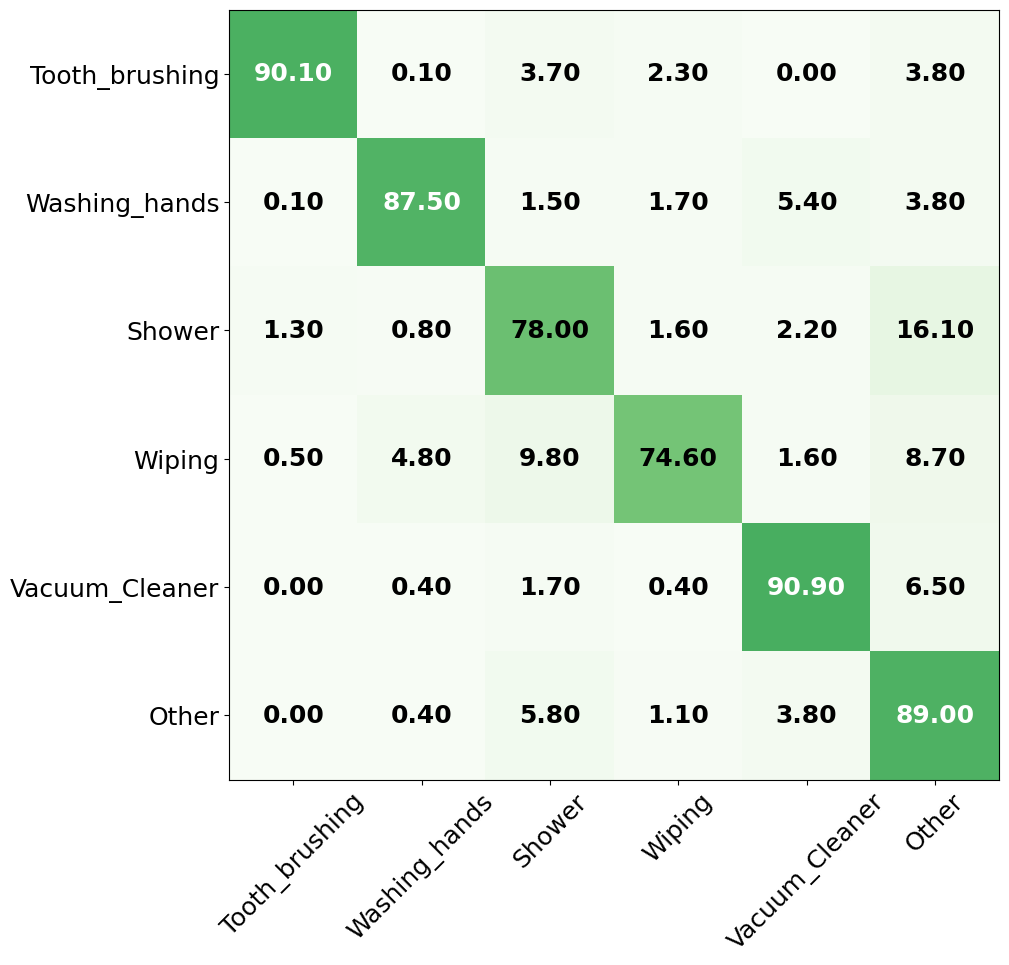

In [1]:
# %%
import tensorflow as tf
import pickle as pkl
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt

# Configuration
MODEL_VERSION = 36
HAND = 'Right'
SUB_SR = 16000
TRAIN_PIDS = [100]
VALID_PIDS = [101]
TEST_PIDS = [102, 103]
CLASS_NAMES = ['Shower', 'Tooth_brushing', 'Washing_hands', 'Vacuum_Cleaner', 'Wiping', 'Other']
CLASS_LABELS = ["S", "TB", "WH", "VC", "W", 'O']
BATCH_SIZE = 64
IMU_SR = 50
STRIDE = 0.2
WIN_LEN_IMU = 2 * IMU_SR
HOP_LEN_IMU = int(IMU_SR * STRIDE)

# Paths
BASE_DIR = Path("../../")
DATA_DIR = BASE_DIR / "Data/Train_Data/3. MMExamples"
MODEL_PATH = BASE_DIR / f"Models/tensorflow_model/Motion/Motion_ver{MODEL_VERSION}/{HAND}/{SUB_SR}/MM_Scratch.h5"
NORM_PARAM_PATH = BASE_DIR / f"Normalization_params/Normalization_params_pickle/normalization_params_{HAND}_ver{MODEL_VERSION}.pkl"
LB_PATH = BASE_DIR / f"LabelBinarizer/Multimodal/Label_binarizer_6_classes.pkl"

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Utility Functions
def load_pickle(file_path):
    with open(file_path, "rb") as f:
        return pkl.load(f)

def frame(data, win_len, hop_len):
    """Create overlapping frames from time-series data."""
    if data.shape[0] < win_len:
        pad_len = win_len - data.shape[0]
        data = np.concatenate([data, np.zeros((pad_len,) + data.shape[1:])], axis=0)
    num_samples = data.shape[0]
    num_frames = 1 + (num_samples - win_len) // hop_len
    shape = (num_frames, win_len) + data.shape[1:]
    strides = (data.strides[0] * hop_len,) + data.strides
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

def get_normalization_params(pids):
    imu_all = []
    for pid in pids:
        data_dir = DATA_DIR / f"{pid}" / HAND / f"{SUB_SR}"
        for file_path in tqdm(data_dir.iterdir()):
            try:
                data = load_pickle(file_path)["IMU"]
                if data.shape[0] == 0: continue
                imu_all.append(data)
            except:
                continue
    imu_concat = np.concatenate(imu_all, axis=0)
    imu_flat = imu_concat.reshape(-1, imu_concat.shape[-1])
    return {
        "max": np.percentile(imu_flat, 80, axis=0),
        "min": np.percentile(imu_flat, 20, axis=0),
        "mean": np.mean(imu_flat, axis=0),
        "std": np.std(imu_flat, axis=0)
    }

def normalize_data(x, norm):
    """Min-max normalize to [-1, 1], then standardize."""
    x_norm = 1 + (x - norm["max"]) * 2 / (norm["max"] - norm["min"])
    x_std = (x_norm - norm["mean"]) / norm["std"]
    return x_std

def load_data(pids, norm_params):
    X_imu, y_all = [], []
    for pid in pids:
        data_dir = DATA_DIR / f"{pid}" / HAND / f"{SUB_SR}"
        for file_path in tqdm(data_dir.iterdir()):
            name = file_path.stem
            _, activity, trial = name.split("---")
            if activity not in CLASS_NAMES:
                continue
            data = load_pickle(file_path)
            imu = data["IMU"]
            if imu.shape[0] == 0: continue
            imu = normalize_data(imu, norm_params)
            X_imu.append(imu)
            y_all.extend([[pid, activity, trial]] * imu.shape[0])
    return (
        np.concatenate(X_imu, axis=0),
        np.array(y_all)
    )

def evaluate_model(model, X_imu, y_true, lb):
    y_pred_prob = model.predict(X_imu, batch_size=BATCH_SIZE)
    y_pred = lb.inverse_transform(y_pred_prob)
    ba = balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Balanced Accuracy: {ba:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")
    return y_pred

def plot_confusion(y_true, y_pred, labels, label_short):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_pct = np.nan_to_num(cm / cm.sum(axis=1, keepdims=True) * 100)

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm_pct, cmap='Blues', vmin=0, vmax=100)

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(label_short, fontsize=16)
    ax.set_yticklabels(label_short, fontsize=16)
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)

    thresh = cm_pct.max() / 2
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, f"{cm_pct[i, j]:.2f}", ha='center', va='center',
                    color='white' if cm_pct[i, j] > thresh else 'black', fontsize=16)
    plt.tight_layout()
    plt.show()

# Load Resources
model = tf.keras.models.load_model(MODEL_PATH)
norm_params = load_pickle(NORM_PARAM_PATH)
lb = load_pickle(LB_PATH)

# Run Inference
X_imu_test, y_array = load_data(TEST_PIDS, norm_params)
X_imu_test   = np.ascontiguousarray(X_imu_test,   dtype=np.float32)

y_true = y_array[:, 1]
y_pred = evaluate_model(model, X_imu_test, y_true, lb)

# Confusion Matrix
plot_confusion(y_true, y_pred, labels=CLASS_NAMES, label_short=CLASS_LABELS)
